In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold

sns.set(style='white', context='notebook', palette='deep')

In [3]:
target = 'label_x'
IDcol = 'user_id'
# test = pd.read_csv('train_and_test_addauthor0/testauthormrg.csv')
train = pd.read_csv('train_and_test_addauthor0/trainauthormrg.csv')
predictors = [x for x in train.columns if x not in [target, IDcol, 'label', 'label_y', 'create_weekendcount']]
train_df = train[predictors]
label_df = train[target]

In [15]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.99]

,column_name,missing_count,missing_ratio


In [14]:
train_df.fillna(-999,inplace=True)

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [4]:
# Cross validate model with Kfold stratified cross val,分层交叉验证
kfold = KFold(n_splits=5)

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


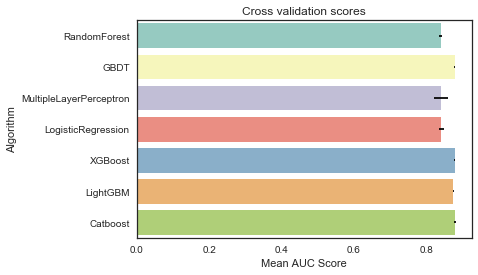

In [16]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
# classifiers.append(SVC(random_state=random_state))
# classifiers.append(DecisionTreeClassifier(random_state=random_state))
# classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
# classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
# classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
# classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(xgb.XGBClassifier(random_state=random_state,objective='binary:logistic'))
classifiers.append(lgb.LGBMClassifier(random_state=random_state,objective='binary:logistic'))
classifiers.append(cb.CatBoostClassifier(random_state=random_state,loss_function='Logloss'))


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X = train_df, y = label_df, scoring = "roc_auc", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["RandomForest","GBDT","MultipleLayerPerceptron","LogisticRegression","XGBoost","LightGBM","Catboost"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean AUC Score")
g = g.set_title("Cross validation scores")

In [17]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.840398,0.003381,RandomForest
1,0.879119,0.001969,GBDT
2,0.841418,0.019752,MultipleLayerPerceptron
3,0.841849,0.006731,LogisticRegression
4,0.879096,0.001990,XGBoost
5,0.875708,0.001249,LightGBM
6,0.880184,0.001866,Catboost
